# Hodgkin and Huxley Action Potential Model
## Jupyter Style

### Preliminaries
First, we'll import some functions that we'll need later, and set the values of some constants. The `%` at the beginning of the first line indicates an `IPython` 'magic'. This will make it possible to display plots in the notebook below.

In [ ]:
%matplotlib inline

from math import exp
from numpy import linspace      # numpy supplies MATLAB-style matrix functionality
import matplotlib.pyplot as plt # matplotlib supplies MATLAB-style plotting functionality

EK = -12 # Potassium Nernst potential in mV
ENa = 115 # Sodium Nernst potential in mV
EL = 10.613 # Leakage Nernst potential in mV
gK = 36 # Max potassium conductance (mS/cm**2)
gNa = 120 # Max sodium conductance (mS/cm**2)
gL = 0.3 # Max leakage conductance (ms/cm**2)
Cm = 1 # uF/cm**2
Vrest = -60 # Membrane resting potential (mV)

### The rate constants $\alpha$ and $\beta$

$$\begin{equation}
\alpha_m = \frac{0.1 \,(25 - V')}{e^{\,(25 - V')\,/\,10} \,+\, 1}\frac{1}{ms}
\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;
\alpha_h = \frac{0.07}{e^{\,V'\,/\,20}}\frac{1}{ms}
\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;
\alpha_n = \frac{0.01 \,(10 - V')}{e^{\,(10 - V')\,/\,10} \,-\, 1}\frac{1}{ms}
\end{equation}$$

$$\begin{equation}
\beta_m = \frac{4}{e^{\,V'\,/\,18}}\frac{1}{ms}
\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;
\beta_h = \frac{1}{e^{\,(30 - V')\,/\,10}\,+\,1}\frac{1}{ms}
\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;
\beta_m = \frac{0.125}{e^{\,V'\,/\,80}}\frac{1}{ms}
\end{equation}$$

It's simple to insert $\LaTeX$ into a notebook markdown cell. Also, most HTML code will work. This and many other easy tricks can be found [here](http://jupyter-notebook.readthedocs.io/en/stable/examples/Notebook/Working%20With%20Markdown%20Cells.html).

We can write a function for each rate constant. This will make our later code much easier to read. A doc string is included in each function; this will make command-line help available.

In [2]:
def alpha_m(voltage):
    """For voltage in millivolts, returns rate constant in 1/milliseconds.
    The voltage value represents membrane potential relative to resting
    potential (voltage = Vm - Vrest)"""
    result = 0.1 * (25 - voltage)
    result /= exp((25 - voltage)/10) - 1
    return result

def beta_m(voltage):
    """For voltage in millivolts, returns rate constant in 1/milliseconds.
    The voltage value represents membrane potential relative to resting
    potential (voltage = Vm - Vrest)"""
    result = 4
    result /= exp(voltage/18)
    return result

def alpha_h(voltage):
    """For voltage in millivolts, returns rate constant in 1/milliseconds.
    The voltage value represents membrane potential relative to resting
    potential (voltage = Vm - Vrest)"""
    result = 0.07
    result /= exp(voltage/20)
    return result

def beta_h(voltage):
    """For voltage in millivolts, returns rate constant in 1/milliseconds.
    The voltage value represents membrane potential relative to resting
    potential (voltage = Vm - Vrest)"""
    result = 1
    result /= exp((30 - voltage)/10) + 1
    return result

def alpha_n(voltage):
    """For voltage in millivolts, returns rate constant in 1/milliseconds.
    The voltage value represents membrane potential relative to resting
    potential (voltage = Vm - Vrest)"""
    result = 0.01 * (10 - voltage)
    result /= exp((10 - voltage)/10) - 1
    return result

def beta_n(voltage):
    """For voltage in millivolts, returns rate constant in 1/milliseconds.
    The voltage value represents membrane potential relative to resting
    potential (voltage = Vm - Vrest)"""
    result = 0.125
    result /= exp(voltage/80)
    return result

Now, if you are running this notebook in a jupyter notebook server, you can interactively edit the code cells and run them individually over and over. So for instance, you could try calling one or more of the functions with any voltage you choose in the code cell below, to make sure the output is what you expect...

In [20]:
voltage = -60
alpha_n(voltage), beta_n(voltage)

(0.0006388999772552137, 0.26462500207658435)

If you are viewing this notebook with a static viewer (or, obviously, if it's been converted to a pdf), you won't be able to edit or run the cells. The notebook server is easily launched in linux by typing "jupyter notebook" at the command line. Maybe this works for Mac's too, I don't know. The only way I know to launch the server in Windows is to install [Canopy Express](https://store.enthought.com/downloads/) and launch it from within their MATLAB-like IDE. Then the notebook will open up in a browser tab.

### Utility functions
We can create a utility function, `stim_current`, for creating stimulus pulses.

In [21]:
def stim_current(amplitude, start, stop, duration, dt):
    """"Creates a square-wave stimulus waveform of length duration and 
    interval dt with amplitude for start < t < stop and zero elsewhere"""
    stim_pulse = []
    N = round(duration/dt)
    times = linspace(0, duration, N)
    for t in times:
        if t > start and t < stop:
            stim_pulse.append(amplitude)
        else:
            stim_pulse.append(0)
    return stim_pulse

After running the cell, let's call the function to see if it behaves as desired...

In [7]:
stim_current(.2,0.2,0.4,0.5,.05)

[0, 0, 0, 0, 0.2, 0.2, 0.2, 0.2, 0, 0]

Here are some more utility functions for calculating currents. It isn't necessary to encapsulate everything into a function like I'm doing, but these makes the code in the main loop below read more like English; easily readable code is part of the Python philosophy. The Python style guide, [PEP8](https://www.python.org/dev/peps/pep-0008/), is well known in the Python community, and while compliance with PEP8 is not required by the interpreter, the intuitive feel of PEP8-compliant code is part of Python's usefulness.

In [8]:
def k_current(conductance, n, voltage):
    """Given max conductance, gating parameter n, and voltage, return
    the potassium current. Voltage should be relative to the ion's
    nernst potential."""
    return conductance * n**4 * voltage
    
def na_current(conductance, m, h, voltage):
    """Given max conductance, gating parameter n, and voltage, return
    the potassium current. Voltage should be relative to the ion's
    nernst potential."""
    return conductance * m**3 * h * voltage
    
def leak_current(conductance, voltage):
    """Given leakage conductance and voltage, return the leakage 
    current. Voltage should be relative to the leakage nernst potential."""    
    return conductance * voltage


### Almost ready ...
Now we just need to set up our signal variables and loop through our differential equations to generate the HH membrane response for the given times.

In [9]:
duration = 10 # milliseconds
dt = 0.01 # time-step for Newton's method (milliseconds)
N = round(duration/dt)
times = linspace(0,duration,N)

stim_amp = 60 # uA
stim_start, stim_stop = 0.2, 0.45 # msec
Id = stim_current(stim_amp, stim_start, stim_stop, duration, dt)
Id.reverse() 

We won't need the waveform for plotting, so by reversing it, we can use `list.pop()` (which removes values last-to-first) within the loop to consume the waveform one value at a time. This avoids the need for an index within the loop, and makes the code a little prettier.

In [10]:
voltage = []
n, m, h = [], [], []
IK, INa, IL = [], [], []

last = -1 # Makes the code a little easier to read

### The main loop
Here's the main loop. We're about to step through Newton's method for several different variables that are interdependent. For the various equations, we might as well get our $\LaTeX$ on again...

$$\begin{equation}
\frac{dn}{dt} = \alpha_n\,(1\,-\,n) - \beta_n\,n
\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;
\frac{dm}{dt} = \alpha_m\,(1\,-\,m) - \beta_m\,m
\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;
\frac{dh}{dt} = \alpha_h\,(1\,-\,h) - \beta_h\,h
\end{equation}$$

$$\begin{equation}
I_K = \bar{g}_K\, n^4 \,(V_m - E_K)
\;\;\;\;\;\;\;\;\;\;\;\;\;
I_{Na} = \bar{g}_{Na}\, m^3 h \,(V_m - E_{Na})
\;\;\;\;\;\;\;\;\;\;\;\;\;
I_L = g_L\, (V_m - E_L)
\;\;\;\;\;\;\;\;\;\;\;\;\;
\frac{dV}{dt} = \frac{I_d - I_K - I_{Na} - I_L}{C_m}
\end{equation}$$

In [11]:
for t in times:
    if t == 0:
        voltage.append(0)
        Id.pop()
    else:
        dv = dt * (Id.pop() - IK[last] - INa[last] - IL[last]) / Cm
        # Newton's method applied to the membrane voltage
        voltage.append(voltage[last] + dv) 

    v = voltage[last]
    an = alpha_n(v)
    am = alpha_m(v)
    ah = alpha_h(v)
    bn = beta_n(v)
    bm = beta_m(v)
    bh = beta_h(v)
    
    if t == 0:
        n.append(an / (an + bn))
        m.append(am / (am + bm))
        h.append(ah / (ah + bh))
    else:
        # Newton's method applied to the gating parameters
        dn = dt * (an * (1 - n[last]) - bn * n[last])
        dm = dt * (am * (1 - m[last]) - bm * m[last])
        dh = dt * (ah * (1 - h[last]) - bh * h[last])
        n.append(n[last] + dn)
        m.append(m[last] + dm)
        h.append(h[last] + dh)
    
    IK.append(k_current(gK, n[last], v  - EK))
    INa.append(na_current(gNa, m[last], h[last], v  - ENa))
    IL.append(leak_current(gL, v - EL))

### Plotting
Plotting in Python is very similar to MATLAB. Jupyter allows inline plotting in a notebook--enabled above by the IPython `magic` in this notebook's first cell--which is very nice. If you run this notebook on a server, and the plot sizes don't match your screen width very well, try playing with the parameters for figure size on the first line...

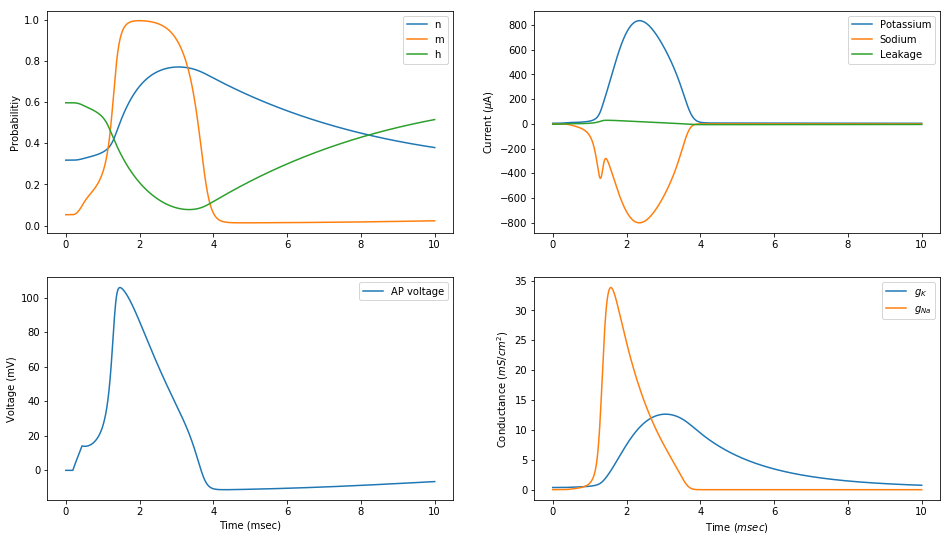

In [19]:
plt.rcParams['figure.figsize'] = (16, 9)
plt.subplot(221)
plt.plot(times, n, label='n')
plt.plot(times, m, label='m')
plt.plot(times, h, label='h') 
plt.ylabel('Probabilitiy')
plt.legend()

plt.subplot(222)
plt.plot(times, IK, label='Potassium')
plt.plot(times, INa, label='Sodium')
plt.plot(times, IL, label='Leakage') 
plt.ylabel('Current ($\mu$A)')
plt.legend()

plt.subplot(223)
plt.plot(times, voltage, label='AP voltage') 
plt.xlabel('Time (msec)')
plt.ylabel('Voltage (mV)')
plt.legend()

gKs = [ gK * x**4 for x in n ]    
gNas = [ gNa * x**3 * y for (x, y) in zip(m, h) ]    
plt.subplot(224)    
plt.plot(times, gKs, label='$g_K$')
plt.plot(times, gNas, label='$g_{Na}$')
plt.xlabel('Time $(msec)$')
plt.ylabel('Conductance $(mS/cm^2)$')
#plt.title('Conductances (action potential)')
plt.legend()
plt.show()